<a href="https://colab.research.google.com/github/jdasam/aat3020-2023/blob/main/notebooks/3_Language_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torchtext.data.utils import get_tokenizer
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


# For Assignment 3

In [15]:
num_tokens=2
input_dim = 5
hidden_dim = 3

torch.manual_seed(0)
x = torch.randn([num_tokens, input_dim])
wi = torch.randn([5, 3])
wf = torch.randn([5, 3])
wc = torch.randn([5, 3])
wo = torch.randn([5, 3])

w_entire = torch.cat([wi, wf, wc, wo], dim=-1)
print(w_entire.shape)

torch.mm(x, wi), torch.mm(x, wf), torch.mm(x, wc), torch.mm(x, wo), torch.mm(x, w_entire)

torch.mm(x, wf) == torch.mm(x,w_entire)[:, 3:6], torch.mm(x, wc) == torch.mm(x,w_entire)[:, 6:9]

torch.Size([5, 12])


(tensor([[True, True, True],
         [True, True, True]]),
 tensor([[True, True, True],
         [True, True, True]]))

# Language modeling

In [16]:
!wget "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"

--2023-05-02 06:37:49--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.01s   

2023-05-02 06:37:49 (16.6 MB/s) - ‘names.txt’ saved [228145/228145]



In [17]:
def read_txt(txt_path):
  with open(txt_path, 'r') as f:
    txt_string = f.readlines()
  return txt_string

txt_string = read_txt('names.txt')

In [18]:
names = [x[:-1] for x in txt_string]
len(names)

32033

In [ ]:
# 2-gram 
entire_ngram = []
n = 5

for name in names:
  len_name = len(name)
  for i in range(len(name)-(n-1)):
    n_gram = name[i:i+n]
    entire_ngram.append(n_gram)

In [ ]:
from collections import Counter

n_gram_counter = Counter(entire_ngram)

In [ ]:
# how many combination exists?
len(n_gram_counter)

In [ ]:
n_gram_counter.most_common(10)

In [ ]:
n_gram_keys = sorted(list(n_gram_counter.keys()))
n_gram_keys

In [ ]:
n_gram_counter['ab']

In [ ]:
starting_characters = list(set([x[0] for x in n_gram_keys]))

example_chr = starting_characters[0]
example_chr
corresp_ngram_words = [x for x in n_gram_keys if x[0] == example_chr]
total_chr_appearance = sum([n_gram_counter[word] for word in corresp_ngram_words])

prob_of_words = [n_gram_counter[x]/total_chr_appearance for x in corresp_ngram_words]


In [ ]:
prob_of_words

In [ ]:
starting_characters = sorted(list(set([x[0] for x in n_gram_keys])))
len(starting_characters)

In [ ]:
# Make transition matrix
import numpy as np

transition = np.zeros([26, 26], dtype=np.int)
chrs = sorted(list(set([x[0] for x in n_gram_keys])))
chrs

In [ ]:
for i, start in enumerate(chrs):
  for j, end in enumerate(chrs):
    transition[i, j] = n_gram_counter[start+end]

In [ ]:
import torch

transition = torch.tensor(transition)
torch.set_printoptions(sci_mode=False)

In [ ]:
trans_prob = transition / transition.sum(dim=1).unsqueeze(1)
trans_prob

In [ ]:
trans_prob[0].sum()

In [ ]:
chrs[16], chrs[20], trans_prob[16, 20]

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(trans_prob)

## Neural Network

In [19]:
import torch
import torch.nn

class Dataset:
  def __init__(self, list_of_names):
    self.names = list_of_names
    self.chrs = sorted(list(set([chr  for name in self.names for chr in name])))
    self.chrs = ['0', '.'] + self.chrs
    self.tok2idx = {chr:i for i, chr in enumerate(self.chrs)}

  def __len__(self):
    return len(self.names)

  def __getitem__(self, idx):
    name = self.names[idx]
    name = '.' + name + '.'
    name_in_indices = [self.tok2idx[chr] for chr in name]
    return torch.tensor(name_in_indices, dtype=torch.long)

dataset = Dataset(names)
dataset[0]

tensor([ 1,  6, 14, 14,  2,  1])

In [20]:
vocab_size = len(dataset.chrs)
emb_dim = 8

word_emb = nn.Embedding(vocab_size, emb_dim)

In [21]:
word_emb.weight[0]

tensor([-0.0250,  1.3694,  2.6570,  0.9851, -0.2596,  0.1183,  0.2440,  1.1646],
       grad_fn=<SelectBackward0>)

In [22]:
name_tensor = dataset[0]
emb = word_emb(name_tensor)

In [23]:
emb.shape

torch.Size([6, 8])

In [24]:
emb[0:1]

tensor([[ 2.6963,  1.2358,  0.5428,  0.5255,  0.1922, -0.7722, -1.9003,  0.1307]],
       grad_fn=<SliceBackward0>)

In [25]:
hidden_size = 12
weight_xh = nn.Linear(emb_dim, hidden_size, bias=False)

weight_xh(emb)

tensor([[ 1.3796, -1.8377,  0.4156,  0.5166,  1.0434,  0.5792,  0.6423,  0.2493,
          0.1545,  0.1691, -0.8445,  1.5963],
        [ 0.6419,  0.4828, -0.1121,  0.0237, -0.6448,  0.0097,  0.2495, -0.5326,
         -0.8332,  1.0272, -0.5502, -0.8975],
        [ 0.0659, -0.7967, -0.0994,  0.1358,  0.2225,  0.1777, -0.0083,  0.4517,
          0.1504,  0.0229, -0.0122,  0.4418],
        [ 0.0659, -0.7967, -0.0994,  0.1358,  0.2225,  0.1777, -0.0083,  0.4517,
          0.1504,  0.0229, -0.0122,  0.4418],
        [-0.6800,  0.6675, -0.7909,  0.0354, -0.3357, -0.6143, -0.4675,  0.5167,
          0.3861,  0.0461,  0.7853, -0.9345],
        [ 1.3796, -1.8377,  0.4156,  0.5166,  1.0434,  0.5792,  0.6423,  0.2493,
          0.1545,  0.1691, -0.8445,  1.5963]], grad_fn=<MmBackward0>)

In [26]:
weight_hh = nn.Linear(hidden_size, hidden_size)

initial_hidden = torch.zeros(hidden_size)

$h_1 = \sigma(W_{hh}h_{0} + W_{xh}x_{1})$


In [27]:
next_hidden = (weight_hh(initial_hidden) + weight_xh(emb[0:1])).tanh()
next_hidden

tensor([[ 0.8498, -0.9618,  0.5130,  0.3653,  0.7169,  0.5035,  0.5473,  0.0244,
          0.3758,  0.0417, -0.6304,  0.9515]], grad_fn=<TanhBackward0>)

In [28]:
timestep = 0
hidden = torch.zeros(hidden_size)
total_hidden = []

for t in range(len(name_tensor)):
  emb_t = word_emb(name_tensor[t])
  hidden = (weight_hh(hidden) + weight_xh(emb_t)).tanh()
  total_hidden.append(hidden)
total_hidden

[tensor([ 0.8498, -0.9618,  0.5130,  0.3653,  0.7169,  0.5035,  0.5473,  0.0244,
          0.3758,  0.0417, -0.6304,  0.9515], grad_fn=<TanhBackward0>),
 tensor([ 0.5362,  0.4522, -0.2529,  0.1942, -0.8287,  0.1292, -0.1969, -0.7994,
         -0.7105,  0.8073, -0.5149, -0.5477], grad_fn=<TanhBackward0>),
 tensor([-0.3492, -0.6185, -0.2800, -0.4926,  0.1397, -0.1797,  0.0792,  0.4161,
          0.6716, -0.4203,  0.0976,  0.5941], grad_fn=<TanhBackward0>),
 tensor([ 0.1792, -0.7061,  0.0105,  0.2904, -0.0639,  0.4500,  0.0670,  0.1684,
          0.1597, -0.0779,  0.2751,  0.5313], grad_fn=<TanhBackward0>),
 tensor([-0.5712,  0.5293, -0.6066,  0.3224, -0.4819, -0.4177, -0.5164,  0.2582,
          0.4855,  0.0533,  0.7115, -0.5538], grad_fn=<TanhBackward0>),
 tensor([ 0.7097, -0.9840,  0.7478,  0.4556,  0.8481,  0.3497,  0.7113,  0.4092,
          0.4547, -0.0431, -0.3242,  0.9247], grad_fn=<TanhBackward0>)]

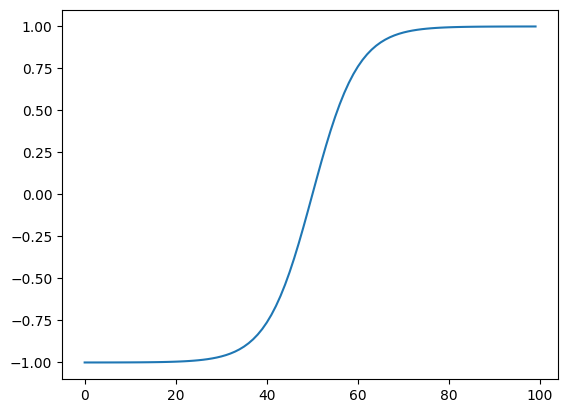

In [29]:
import matplotlib.pyplot as plt
plt.plot(((torch.arange(100) - 50)/10).tanh())

# Language Model

In [84]:
class LanguageModel(nn.Module):
  def __init__(self, vocab_size, emb_dim, hidden_size):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    # self.rnn = nn.RNN(emb_dim, hidden_size, num_layers=1, batch_first=True)
    self.rnn = nn.GRU(emb_dim, hidden_size, num_layers=3, batch_first=True)
    self.proj = nn.Linear(hidden_size, vocab_size)

  def forward(self, x):
    emb = self.emb(x)
    out, _ = self.rnn(emb)
    out = self.proj(out)
    return out
  
dataset = Dataset(names)

vocab_size = len(dataset.chrs)
emb_dim = 64
hidden_size = 128
model = LanguageModel(vocab_size, emb_dim, hidden_size)
  

In [31]:
def get_nll(pred, target):
  pred = pred.reshape(-1, pred.shape[-1])
  target = target.reshape(-1)
  pred_masked = pred[target!=0]
  target_masked = target[target!=0]
  
  return -torch.log(pred_masked[torch.arange(len(target_masked)), target_masked] + 1e-8).mean()

In [32]:
def pad_collate_fn(batch):
  batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0)
  return batch

In [85]:

dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=pad_collate_fn)

model = LanguageModel(vocab_size, emb_dim, hidden_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = model.train()
dev = 'cuda'
# dev='cpu'
model.to(dev)
loss_fn = get_nll
n_epoch = 20
loss_record = []

for epoch in range(10):
  for batch in tqdm(dataloader, leave=False):
    batch = batch.to(dev)
    x = batch[:, :-1]
    y = batch[:, 1:]
    
    optimizer.zero_grad()
    out = model(x)
    loss = loss_fn(out.softmax(dim=-1), y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_record.append(loss.item())

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

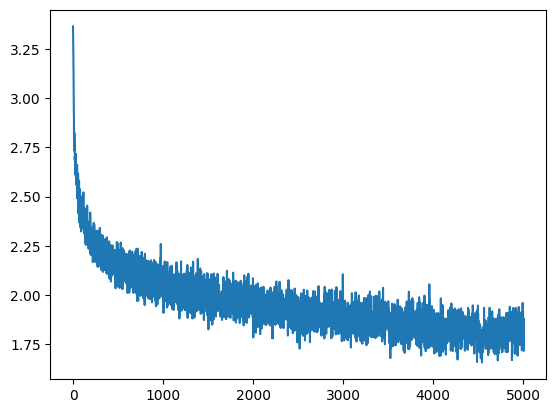

In [86]:
plt.plot(loss_record)

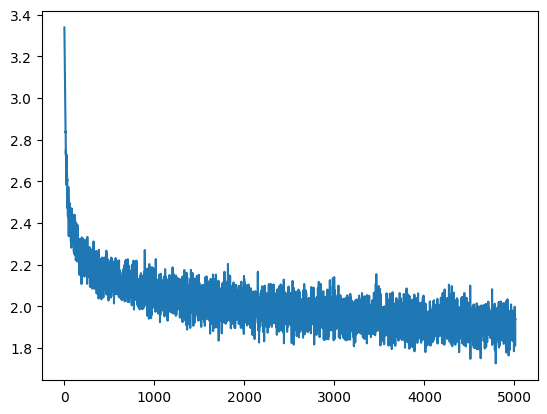

In [77]:
plt.plot(loss_record)

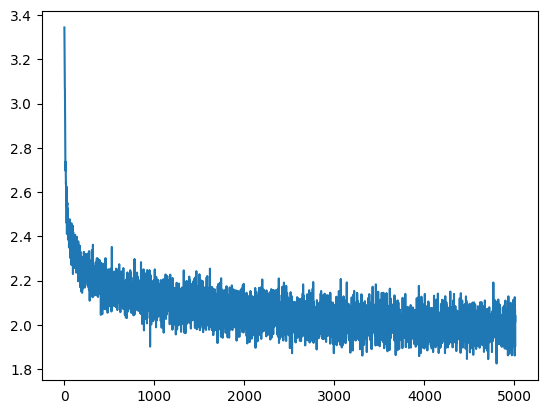

In [37]:
plt.plot(loss_record)

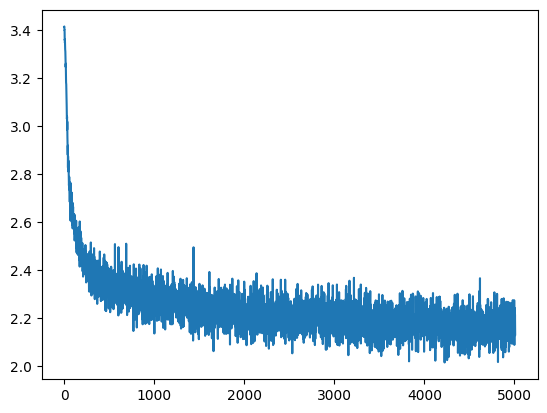

In [34]:
plt.plot(loss_record)

In [88]:
model.cpu()

LanguageModel(
  (emb): Embedding(28, 64)
  (rnn): GRU(64, 128, num_layers=3, batch_first=True)
  (proj): Linear(in_features=128, out_features=28, bias=True)
)

In [52]:
torch.set_printoptions(sci_mode=False)

In [97]:
prompt = '.'
prompt_in_idxs = [dataset.tok2idx[x] for x in prompt]

input_tensor = torch.tensor(prompt_in_idxs)
last_hidden = torch.zeros([model.rnn.num_layers, 1, model.rnn.hidden_size]) # num_layers x num_batch x hidden_size

sampled_idx = input_tensor[0]

total_output = []
model.eval()
with torch.inference_mode():
  while True:
    emb = model.emb(sampled_idx.unsqueeze(0).unsqueeze(0))
    out, last_hidden = model.rnn(emb, last_hidden)
    out = model.proj(out)
    prob = out.softmax(dim=-1)
    sampled_idx = prob.squeeze().multinomial(num_samples=1).squeeze()
    if sampled_idx == dataset.tok2idx['.']:
      break
    total_output.append(sampled_idx.item())
    # prob, sampled_idx
print(total_output)
output_text = ''.join([dataset.chrs[x] for x in total_output]) # change char index to character
output_text


[26, 16, 22, 20, 9, 22, 19]


'youshur'

In [65]:
dataset.chrs

AttributeError: ignored